Adding solar system object (SSO) metric capabilities to [MAF](https://confluence.lsstcorp.org/display/SIM/MAF+documentation) moves far enough beyond the current concepts of slicers + metrics in MAF that it seems worthwhile to prototype the functionality required, test the best approaches, and then see how we should map this back into classes for MAF. 

The general concept in MAF (for stationary objects) is: 
* read the pointing history from the opsim sqlite database
* determine how to subdivide the pointing history appropriately for a desired metric measurement + use the appropriate `slicer` to do so
* iterate over the `slicer` and apply a `metric` (python class which makes a measurement on a given data slice) at each slice|
* consolidate the metric results at each slicepoint, as appropriate given the slicer (i.e. make a skymap, etc.)

For moving objects, we have additional steps and instead of the metric being applied per "subdivision of the pointing history" (per RA/Dec pointing, for example), we probably want to think of the metric being applied "per SSO". 
So the steps could be:
* read the orbital parameters and Hmag for each SSO
* read the pointing history from the opsim sqlite database
* determine when each individual object would be detected and what its magnitude would be in each detection (potentially, only record observations where the detection is > 5sigma??)
* apply metric based on observations
*  .. additional wrinkles: because this is slow (per object), we are also interested in (a) saving the pointing history for all objects, potentially also saving steps needed to create this pointing history for different opsim runs, and (b) allowing each object to be cloned to a variety of different H mags (equivalent to cloning over the size distribution, so that each single orbital parameter set represents a range of different objects). 

---

In [94]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from itertools import repeat
import scipy
from scipy import interpolate
import pandas
import pyoorb as oo

Get the pointing history information from the opsim sqlite output.

In [125]:
from lsst.sims.maf.db import OpsimDatabase
from lsst.sims.utils import haversine

In [96]:
dbAddress = 'sqlite:///enigma_1189_sqlite.db'
ops = OpsimDatabase(dbAddress)

In [171]:
dbcols = ['expMJD', 'fieldRA', 'fieldDec', 'rotSkyPos', 'filter', 'finSeeing', 'fiveSigmaDepth']
simdata_long = ops.fetchMetricData(dbcols, sqlconstraint='')
simdata_short = ops.fetchMetricData(dbcols, sqlconstraint='night<365')
print simdata_long.dtype.names
print simdata_long[0]

('obsHistID', 'expMJD', 'fieldRA', 'fieldDec', 'rotSkyPos', 'filter', 'finSeeing', 'fiveSigmaDepth')
(1, 49353.032079, 1.676483, -1.082473, 1.280457, 'y', 0.954372, 21.084291)


---
Read the moving object orbital information. For now, we'll use pandas to read it in and then convert to a numpy recarray, but this should be done in MAF later, similarly to how the opsim pointings are read.

In [114]:
orbits = pandas.read_table('pha20141031.des', sep=' ')

In [115]:
orbits[0:3]

,!!ObjID,FORMAT,q,e,i,Omega/node,omega/argperi,t_p,magHv,t_0,INDEX,N_PAR,MOID,COMPCODE
0,0,COM,0.186523,0.826961,22.827817,88.024464,31.358208,49090.767296,20,49353.16,1,6,10,PYOORB
1,1,COM,0.827770,0.335431,13.337659,337.219357,276.868840,48990.932835,20,49353.16,1,6,10,PYOORB
2,2,COM,0.646745,0.560063,6.353077,35.696938,285.875200,49239.645606,20,49353.16,1,6,10,PYOORB


In [116]:
orbits = orbits.to_records()
print len(orbits), orbits.dtype.names, orbits[0]

1510 ('index', '!!ObjID', 'FORMAT', 'q', 'e', 'i', 'Omega/node', 'omega/argperi', 't_p', 'magHv', 't_0', 'INDEX', 'N_PAR', 'MOID', 'COMPCODE') (0, 0, 'COM', 0.1865233429220149, 0.82696095, 22.827817, 88.02446399999998, 31.358208, 49090.767295844285, 20.0, 49353.16, 1, 6, 10, 'PYOORB')


Now we have some options to test. It's too expensive to calculate ephemerides for every object at the time of every opsim pointing, so we want to calculate positions on a coarse grid of times - let's start with calculating the positions every 2 hours for PHAs.  There are a few options for doing this: 
* (1) We could calculate the rough positions using [OpenOrb](https://code.google.com/p/oorb/wiki/OpenOrb) directly at the command line, for the full ten years. This is is efficient because it calculates the positions for all objects at once, meaning we only have to calculate things like the positions of the planets and Earth once for each time. A test on my laptop created a 10 year 2-hr grid of ephemerides in about 2 hours, producing a 42GB output file. The problems here are that you have to keep a fairly large output file (not something you'd like to read into memory as-is) and that the contents of the file are not in the order that we'd like (ordered by time, then object). I'll come back to this if the approaches below don't work out.
* (2) We could calculate the rough positions using the python bindings to OpenOrb, for each object over the full ten years, then calculate the actual observations matching opsim pointings, then write to disk. This is less efficient because the calculation of the Earth and planets' positions are repeated, but will be tested below. 
* (3) We could calculate the rough positions using the python bindings to OpenOrb, but do it for all objects at once .. since the full results won't fit in memory, we could do it month-by-month (or some other time step). This is efficient only if we can also propagate and save the orbits at each interval; otherwise we have to re-propagate the orbits over the gap between their epoch and the start of observations every time. I'm not entirely sure the propagation routines have working python bindings, but will test below. This is a nice approach, although it doesn't quite fit into the "per object" concept as cleanly. 

Testing ephemeris generation, along the style of option (2) above. <br>
Because pyoorb is a python interface to a Fortran program (OpenOrb), written very simply with f2py, we have to do some awkwardness with array-rearranging.

In [117]:
timestep = 2.0 / 24.0  # in days
timestart = simdata_short['expMJD'][0]
testshort = 1.5 # years
timeend = timestart + 365 * testshort + 1.0
times_short = np.arange(timestart, timeend + timestep/2.0, timestep)
testlong = 10.0 # years
timeend = timestart + 365 * testlong + 1.0
times_long = np.arange(timestart, timeend + timestep/2.0, timestep)
# For pyoorb, we need to tag times with timescales;
# 1= MJD_UTC, 2=UT1, 3=TT, 4=TAI
ephTimes_short = np.array(zip(times_short, repeat(4, len(times_short))), dtype='double', order='F')
ephTimes_long = np.array(zip(times_long, repeat(4, len(times_long))), dtype='double', order='F')
print ephTimes_short.shape
print ephTimes_long.shape

(6583, 2)
(43813, 2)


Set up pyoorb (reads in JPL ephemerides for major planets, etc.). 

In [102]:
oo.pyoorb.oorb_init(ephemeris_fname="")

1

Python oorb element format: 
        # Translate orbital elements into array that pyoorb will like.
        # PyOrb wants ::
        # 0: orbitId  (cannot be a string)
        # 1 - 6: orbital elements, using radians for angles
        # 7: element type code, where 2 = cometary - means timescale is TT, too
        # 8: epoch
        # 9: timescale for the epoch; 1= MJD_UTC, 2=UT1, 3=TT, 4=TAI
        # 10: magHv
        # 11: G
so we have to do a little translating from the orbits DataFrame to the elements we want in this array. 

In [118]:
def packOorbElem(sso):
    oorbelems = [sso['!!ObjID'], sso['q'], sso['e'], np.radians(sso['i']), np.radians(sso['Omega/node']), 
             np.radians(sso['omega/argperi']), sso['t_p'],  2, sso['t_0'], 3, sso['magHv'], 0.15]
    oorbelems = np.column_stack(oorbelems)
    return oorbelems

In [119]:
%%timeit
print testlong, ' (years of ephemerides)'
for sso in orbits[0:1]:
    print sso
    oorbelems = packOorbElem(sso)
    oorbephs, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes_long)

10.0  (years of ephemerides)
(0, 0, 'COM', 0.1865233429220149, 0.82696095, 22.827817, 88.02446399999998, 31.358208, 49090.767295844285, 20.0, 49353.16, 1, 6, 10, 'PYOORB')
10.0  (years of ephemerides)
(0, 0, 'COM', 0.1865233429220149, 0.82696095, 22.827817, 88.02446399999998, 31.358208, 49090.767295844285, 20.0, 49353.16, 1, 6, 10, 'PYOORB')
10.0  (years of ephemerides)
(0, 0, 'COM', 0.1865233429220149, 0.82696095, 22.827817, 88.02446399999998, 31.358208, 49090.767295844285, 20.0, 49353.16, 1, 6, 10, 'PYOORB')
10.0  (years of ephemerides)
(0, 0, 'COM', 0.1865233429220149, 0.82696095, 22.827817, 88.02446399999998, 31.358208, 49090.767295844285, 20.0, 49353.16, 1, 6, 10, 'PYOORB')
1 loops, best of 3: 8.81 s per loop


Just under 9 seconds per object to calculate the coarse grid over 10 years. For many simulations, I think we'd have on the order of 1000-2000 objects = 2.5 - 5 hours for this step, done like this.  I tested ephemeris generation separately of the numpy-array-reordering and the time was very similar, so most of the time is indeed going into pyoorb.

And also, more awkwardness with the ephems and elems arrays:
       # Returned ephems contain a 3-D Fortran array of ephemerides, the axes are:
        #   [objid][time][ephemeris information element]
        # the ephemeris information elements are (in order):
        # distance, ra, dec, mag, ephem mjd, ephem mjd timescale, dradt(sky), ddecdt(sky)
        # per object, per date, 8 elements (array shape is OBJ(s)/DATE(s)/VALUES)
        # Note that ra/dec, dradt, etc. are all in DEGREES.

In [120]:
def unpackEphs(oorbephem):
    # oorbephem = single ephem - i.e. for single object. 
    # then swap time/ephemeris element, so that we can get easy arrays of things like 'ra', 'dec'.
    oorbephem = np.swapaxes(oorbephem, 0, 1)
    dist = oorbephem[0]
    ra = oorbephem[1]
    dec = oorbephem[2]
    magV = oorbephem[3]
    time = oorbephem[4]
    dradt = oorbephem[6]
    ddecdt = oorbephem[7]
    phaseangle = oorbephem[8]
    solarelon = oorbephem[9]
    ephs = np.rec.fromarrays([time, ra, dec, dradt, ddecdt, dist, magV, phaseangle, solarelon], 
                             names=['time', 'ra', 'dec', 'dradt', 'ddecdt', 'dist', 'magV', 'phaseangle', 'solarelon'])
    return ephs

All right, let's test interpolating the coarse ephemerides to all the times in opsim. 

In [121]:
def interpolateEphs(ephs):
    interpfuncs = {}
    for n in ephs.dtype.names:
        if n == 'time':
            continue
        interpfuncs[n] = interpolate.interp1d(ephs['time'], ephs[n], kind='linear', assume_sorted=True, copy=False)
    return interpfuncs

0.0
0.0
0.0
0.0
0.0
6.95277169172e-15
2.16840434497e-19
2.77555756156e-17


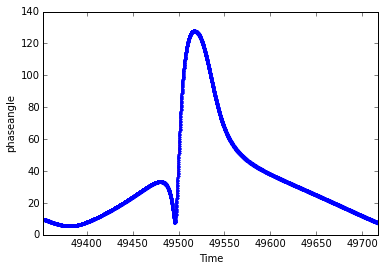

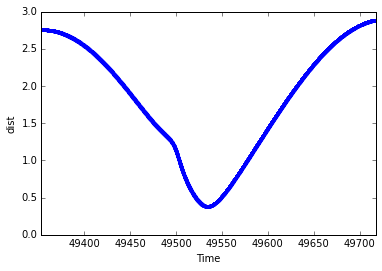

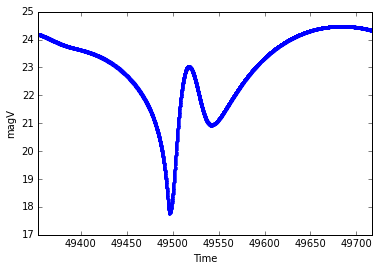

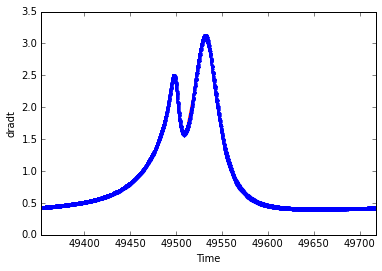

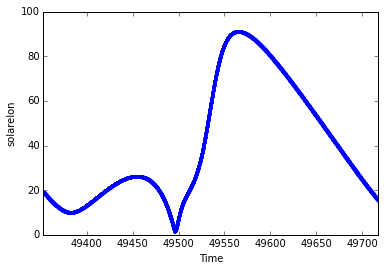

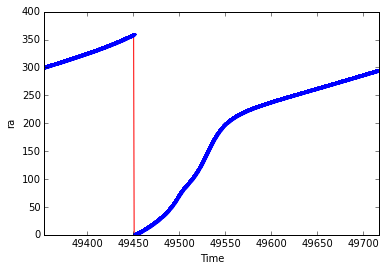

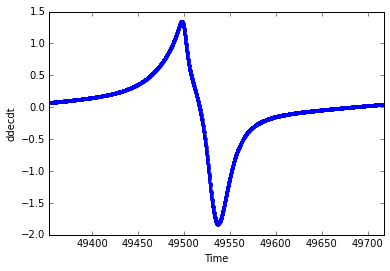

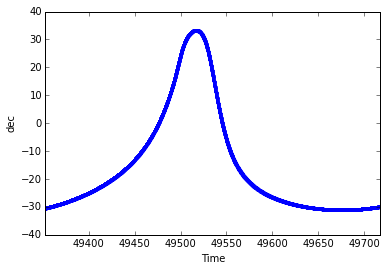

In [123]:
obstimes = simdata_short['expMJD']
for sso in orbits[0:1]:
    oorbelems = packOorbElem(sso)
    oorbephems, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes_short)
    ephs = unpackEphs(oorbephems[0])
    interpfuncs = interpolateEphs(ephs)
    # Have a look.
    for n in interpfuncs:
        plt.figure()
        plt.plot(obstimes, interpfuncs[n](obstimes), 'r-')
        plt.plot(ephs['time'], ephs[n], 'b.')
        plt.xlim(obstimes[0], obstimes[-1])
        plt.xlabel('Time')
        plt.ylabel(n)
    # Test max error.
    for n in interpfuncs:
        diff = ephs[n] - interpfuncs[n](ephs['time'])
        print diff.max()

In [124]:
%%timeit
# Check the timing
for sso in orbits[0:1]:
    oorbelems = packOorbElem(sso)
    oorbephems, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes_long)
    ephs = unpackEphs(oorbephems[0])
    interpfuncs = interpolateEphs(ephs)

1 loops, best of 3: 9.11 s per loop


Awesome. Still about 9s per object with the interpolation. <br>
Let's add the step of checking the positions against the opsim pointings, to determine when the object might actually have been seen.

In [136]:
def ssoInFov(interpfuncs, simdata, rFov=np.radians(1.75), raCol='fieldRA', decCol='fieldDec'):
    raSso = np.radians(interpfuncs['ra'](simdata['expMJD']))
    decSso = np.radians(interpfuncs['dec'](simdata['expMJD']))
    sep = haversine(raSso, decSso, simdata[raCol], simdata[decCol])
    tObs = simdata['expMJD'][np.where(sep<rFov)]
    return tObs

In [169]:
for sso in orbits[0:1]:
    oorbelems = packOorbElem(sso)
    oorbephems, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes_long)
    ephs = unpackEphs(oorbephems[0])
    interpfuncs = interpolateEphs(ephs)
    tvis = ssoInFov(interpfuncs, simdata_long)
    obs = np.recarray([len(tvis)], dtype=ephs.dtype)
    for n in interpfuncs:
        obs[n] = interpfuncs[n](tvis)
    obs['time'] = tvis

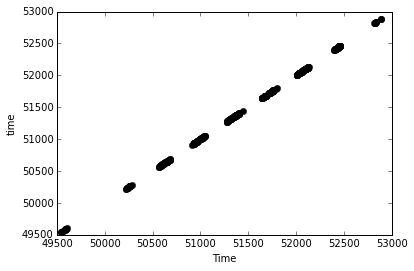

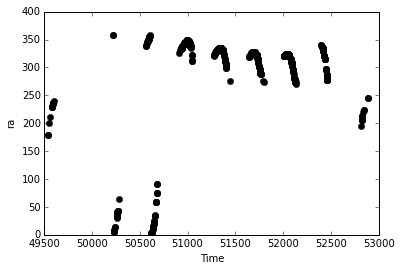

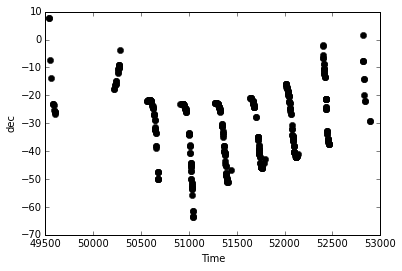

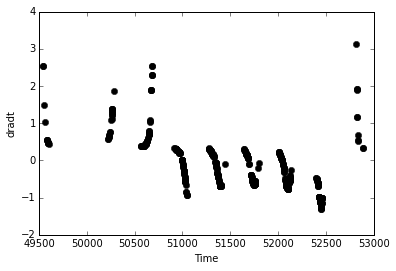

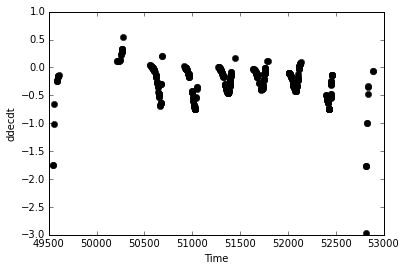

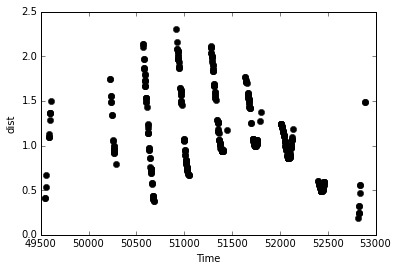

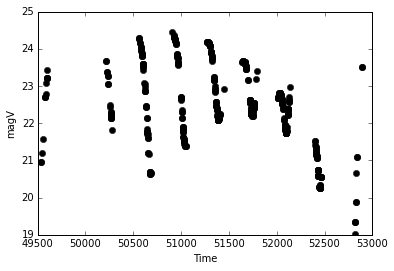

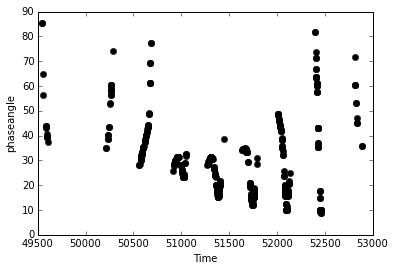

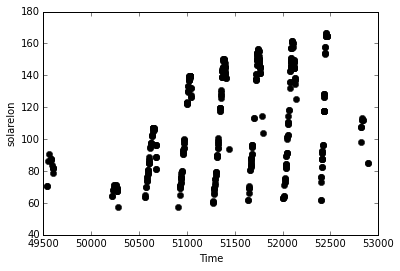

In [170]:
for n in obs.dtype.names:
    plt.figure()
    plt.plot(obs['time'], obs[n], 'ko')
    plt.xlabel('Time')
    plt.ylabel(n)

Great! So we still need to add the chip footprint and cloning (not to mention comparing with the limiting magnitude and including trailing losses) but this gets us a long way there.

In [174]:
# For the footprint generation and conversion between galactic/equatorial coordinates.
from lsst.obs.lsstSim import LsstSimMapper
from lsst.sims.coordUtils import CameraCoords, AstrometryBase
from lsst.sims.catalogs.generation.db.ObservationMetaData import ObservationMetaData

In [175]:
mapper = LsstSimMapper()
camera = mapper.camera
myCamCoords = CameraCoords()
epoch = 2000.0
obs_metadata = ObservationMetaData(m5=0.)
astrometryObject = AstrometryBase()

In [179]:
# Something not quite working here yet.
def ssoInFovChip(interpfuncs, simdata, rFov=np.radians(1.75), raCol='fieldRA', decCol='fieldDec'):
    raSso = np.radians(interpfuncs['ra'](simdata['expMJD']))
    decSso = np.radians(interpfuncs['dec'](simdata['expMJD']))
    sep = haversine(raSso, decSso, simdata[raCol], simdata[decCol])
    idxObs = np.where(sep<rFov)
    tObs = []
    for idx in idxObs:
        obs_metadata.unrefractedRA = simdata[idx][raCol]
        obs_metadata.unrefractedDec = simdata[idx][decCol]
        obs_metadata.rotSkyPos = simdata[idx]['rotSkyPos']
        obs_metadata.mjd = simdata[idx]['expMJD']
        chipNames = myCamCoords.findChipName(ra=interpfuncs['ra'](simdata[idx]['expMJD']),
                                             dec=interpfuncs['dec'](simdata[idx]['expMJD']),
                                             epoch=epoch, camera=camera, obs_metadata=obs_metadata)
        if chipNames != [None]:
            tObs.append(simdata[idx]['expMJD'])
    tObs = np.array(tObs)
    return tObs

So let's test writing this observation information to disk. This is what we'd read back in, then clone / check against limiting magnitudes, etc.

In [196]:
outfile = open('phas_obs.txt', 'w')
# Add Header.
writestring = '!!ObjID'
names=['time', 'ra', 'dec', 'dradt', 'ddecdt', 'dist', 'magV', 'phaseangle', 'solarelon']
for n in names:
    writestring += ' %s' %(n)
print >> outfile, writestring
for sso in orbits[0:3]:
    oorbelems = packOorbElem(sso)
    oorbephems, err = oo.pyoorb.oorb_ephemeris(in_orbits = oorbelems, in_obscode=807, in_date_ephems=ephTimes_long)
    ephs = unpackEphs(oorbephems[0])
    interpfuncs = interpolateEphs(ephs)
    tvis = ssoInFov(interpfuncs, simdata_long)
    obs = np.recarray([len(tvis)], dtype=ephs.dtype)
    for n in interpfuncs:
        obs[n] = interpfuncs[n](tvis)
    obs['time'] = tvis
    for i in range(len(obs['time'])):
        writestring = '%s' %(sso['!!ObjID'])
        for n in names:
            writestring += ' %f' %(obs[n][i])
        print >> outfile, writestring
outfile.close()

For three objects, over 10 years, this was 29s per loop (about 10s per object). Approaching three hours for 1k objects, without chip gaps.

In [197]:
rephs = pandas.read_table('phas_obs.txt', sep=' ')
rephs[0:10]

,!!ObjID,time,ra,dec,dradt,ddecdt,dist,magV,phaseangle,solarelon
0,0,49540.020904,178.554032,7.853679,2.528473,-1.748626,0.407790,20.969447,85.525581,70.905495
1,0,49540.022240,178.557442,7.851342,2.528475,-1.748593,0.407799,20.969421,85.522381,70.908222
2,0,49551.046682,200.570394,-7.461066,1.479888,-1.019466,0.535782,21.186842,64.953142,86.517586
3,0,49558.967844,210.695199,-13.963580,1.033093,-0.651579,0.664376,21.584801,56.410765,90.570482
4,0,49582.055036,228.996795,-23.126172,0.558313,-0.236947,1.093462,22.704030,43.816950,87.775369
5,0,49582.067089,229.004122,-23.129020,0.558931,-0.236634,1.093695,22.704537,43.812622,87.770964
6,0,49582.071158,229.006596,-23.129982,0.559140,-0.236528,1.093774,22.704708,43.811162,87.769477
7,0,49584.075408,230.223606,-23.595393,0.542327,-0.220944,1.132292,22.786552,43.091414,87.049127
8,0,49592.074366,234.797859,-25.184440,0.491264,-0.172244,1.286079,23.087983,40.471944,83.803332
9,0,49596.030005,236.933857,-25.842554,0.471493,-0.154525,1.361852,23.222831,39.284670,82.027242


In [204]:
rephs = rephs.to_records()

---
So we now have the ability to create a list containing all of the observations for the SSOs of interest, save to disk and read back in. (obviously, all of these methods need some cleanup, and I should add in the chip gaps). 

Let's try applying a metric to these observations. Something simple like "How many observations did each object get, total, where SNR > 5?"

In [213]:
def calcColors(sedname='C.dat'):
    # Calculate SSO colors.
    import os
    import lsst.sims.photUtils.Bandpass as Bandpass
    import lsst.sims.photUtils.Sed as Sed
    filterdir = os.getenv('LSST_THROUGHPUTS_BASELINE')
    filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
    lsst ={}
    for f in filterlist:
        lsst[f] = Bandpass()
        lsst[f].readThroughput(os.path.join(filterdir, 'total_'+f+'.dat'))
    vband = Bandpass()
    vband.readThroughput('harris_V.dat')
    csed = Sed()
    csed.readSED_flambda(sedname)
    vmag = csed.calcMag(vband)
    dmags = {}
    for f in filterlist:
        dmags[f] = csed.calcMag(lsst[f]) - vmag
    return dmags

In [215]:
filterlist = ('u', 'g', 'r', 'i', 'z', 'y')
dmags = calcColors()
for f in filterlist:
    print f, dmags[f]
# Example:
print '---'
v = 20
for f in filterlist:
    print f, v+dmags[f]

u 1.6144033523
g 0.302320621737
r -0.172306859497
i -0.291351785733
z -0.298075537869
y -0.30256349639
---
u 21.6144033523
g 20.3023206217
r 19.8276931405
i 19.7086482143
z 19.7019244621
y 19.6974365036


In [243]:
dmags = calcColors()
tol = 1e-8
def nObsMetric(ssoObs, simdata):
    countObs = 0
    for obs in ssoObs:
        # Find matching simdata observation
        simObs = simdata[np.where(np.abs(simdata['expMJD']-obs['time']) < tol)][0]
        # Calculate the magnitude of this object in this filter
        magObs = obs['magV'] + dmags[simObs['filter']]
        # Account for trailing losses by adjusting equivalent depth of exposure.
        vel = np.sqrt(obs['dradt']**2 +obs['ddecdt']**2)  #deg/day
        vel = vel / 24.0  # "/s
        # See https://listserv.lsstcorp.org/mailman/private/lsst-solarsystem/2006-December/24.html
        # should grab simObs['expTime'] .. 
        t = 30.0 # "
        teff = t/(1+1.6*vel*t/simObs['finSeeing'])
        dmT = 1.25*np.log10(teff)
        snr = 5 * np.power(10, 0.4*(magObs - simObs['fiveSigmaDepth'] - dmT))
        if snr > 5:
            countObs += 1
    return countObs

In [244]:
ssos = np.unique(rephs['!!ObjID'])
for sso in ssos:
    obs = rephs[np.where(rephs['!!ObjID'] == sso)]
    nobs = nObsMetric(obs, simdata_long)
    print sso, nobs

0 51
1 0
2 32


In [246]:
# just curious how many observations there were before mag cutoff
for sso in ssos: 
    obs = rephs[np.where(rephs['!!ObjID'] == sso)]
    print sso, len(obs)
# hmm, there were a lot .. were most in z/y bands? or what was cause of loss?

0 501
1 74
2 191


We also need to let the user clone each object and according to a size distribution, but perhaps this should be part of the metric - scaling the metric results to a wider H range after the fact?? 
Using a size distribution like 
\begin{equation}
log(N)=a+kSD \times H \\
N(H) = N_{H=20} \, 10^{kSD \times (H-20)} ?? \\
kSD = 0.30
\end{equation}